## Task 01: Regional Flash Flood in Germany on 2021-07-14

Version: V001, 2022-07-11, rb

## 1. Introduction

In a confined stripe from the German-Dutch-Belgium border reaching North East extreme rainfall occurred between 2021-07-14 and 2021-07-15 having led to devastating flash floods in several small river catchments. The BBC gives a good overview of the catastrophe having caused many casualties and severe damage. 

To get an overview **read the article [BBC News: Germany floods: Where are the worst-hit areas?](https://www.bbc.com/news/world-europe-57862894)**

The intention of this task is to analyse the precipitation events in the five selected catchments **Rur, Erft, Ahr, Wupper, Ruhr.** The openly accessible **hourly precipitation time series** of the **[German National Weather Service (Deutscher Wetterdient, DWD](https://www.dwd.de/EN/Home/home_node.html))** form the basis of the analysis. But as expected, due to the severity of the rain event, many DWD measuring stations were unfortunately affected so severely that precipitation measurements failed and the time series were interrupted. 

It is generally not easy to obtain reliable measurement data for such catastrophic events, which is why quantitative analyses of extreme events are often based on estimates and assumptions. 

<img src="./images/QGIS_p01_Germany_Flood_p01.png" width=1000 /> <br>
_Fig. 1.1: RADOLAN spatial precipitation distribution accumulated between 2021-07-13T12:50UTC and 2021-07-15T12:55UTC (two days) and the river catchments affected most by the extreme rain rates. The brightest pink areas show precipitation heights above 80 mm._

### Import the Necessary Python Libraries

After that poeration you should have library aliases `np, pd, plt`.

In [75]:
# import ...
# import ...
# import ...


## 2. Catchment Areas of the Rivers Rur, Erft, Ahr, Wupper and Ruhr

**Familiarize yourself with the catchment areas.**


**Q 2.1:** Determine the **lengths** of the rivers as well their catchment **areas** (aka river basin area). 
Use **Wikipedia** to get the information, e.g. for river Rur see [this link](https://en.wikipedia.org/wiki/Rur).
<br>
**Fill the values into the CSV file [catchments.csv](catchments.csv)** using any **text editor**, e.g. `notepad++` on Windows. 

**Q 2.2:** Read the file `catchment.csv` into a pandas **data frame** named `df_catch`. Make the column `River` the **index**. 
Rename the columns: 
* `'River' -> 'river'`
* `'Length (km)' -> 'length'`
* `'Area (km^2)' -> 'area'` 
* `'Weather Station Name' -> 'station_name'` 
* `'Weather Station ID' -> 'station_id'` 

by means of the function [pandas.DataFrame.rename(...)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html). 
<br>Use a **dictionary** as a mapper to perform the renaming in the pandas data frame.

In [68]:
# rename_dict = {'...' : '...' , '...' :'...' ...}

# df_catch = pd.read_csv(..., encoding="cp1252")

# df_catch.rename(... , inplace = True)

# df_catch.set_index(...)

# df_catch.head(10)

The data frame `df_catch` should look similar to this:

<img src="images/df_catch_NaN.png" width=300 />

but with the columns `area` and `length` filled.

**Q 2.3:** Use matplotlib to create two separate subplots (two "axes") arranged horizontally in one figure with vertical bar graphs for length and area, respectively.

In [65]:
# fig, (ax1, ax2) = ...

# ax1.bar(...)
# alternative: 
# df_catch[...].plot.... (ax = ax1, ...)
# ...


## 3. Selected Weather Stations

The map below shows the DWD precipitation stations as listed in DWD station description [RR_Stundenwerte_Beschreibung_Stationen.txt](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt).

**Meaning of file name elements, translation:**

| Deutsch | Englisch |
| :--- | :--- |
| RR (Regenrate) | rain rate |
| Stundenwerte | hourly values |
| Beschreibung Stationen | description stations |

<img src="./images/QGIS_p03_EZG_HW_Allt_Rain_Gauges.png" width=1000 /><br>
_Fig. 3.1: DWD precipitation stations with hourly resolution._
Data taken from DWD's [RR_Stundenwerte_Beschreibung_Stationen.txt](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt) 


### Criteria for the Selection of the Weather Stations

The analysis is limited to the catchments of the five rivers Rur, Erft, Ahr, Wupper and Ruhr. 
<br>Only one station per catchment is analysed.

* The station is either in the Rur, Erft, Ahr, Wupper or Ruhr catchment.
* The station is in a heavy rain zone (bright pink).
* The station was continuously fully functional in the chosen time interval.

The search for suitable stations that did not fail during the severe storm proves to be very time-consuming. 
<br>To reduce the workload, the **names of the weather stations to be used** are given:

| station_name | station_id | catchment | 
| :--- | :--- | :--- | 
| Bad-Neuenahr, Ahrweiler | ? | ? |
| Weilerswist-Lommersum | ? | ? |
| Essen-Bredeney | ? | ? |
| Kall-Sistig | ? | ? |
| Wipperfürth-Gardeweg | ? | ? |

**Q 3.1:** Use the file `RR_Stundenwerte_Beschreibung_Stationen.txt` to determine the corresponding station IDs. 
<br>Fill the station IDs in the column `station_id` of the **markdown table** above!

**Q 3.2:** Which weather station is in which cathcment? Use **Fig. 3.1** above to **locate the stations** by means of their station ID in the catchments. 
<br>Fill in the column `catchment` of above **markdown table** with the catchment names (aka 'river').

**Q 3.3** Use any text editor to enter the determined values into the `catchments.csv` file. Fill the columns `weather station name` and `weather station ID` in the CSV file with the determined information. Pay attention to the correct row assignment. 
<br>Execute the code of task `Q 2.3` to **re-read the CSV file** into the data frame `df_catch` again, including the renaming of the data frame columns.


In [8]:
# Code


The data frame `df_catch` should look similar to this but **with all cells filled** (no NaN anymore):

<img src="images/df_catch_NaN.png" width=300 />

## 4. Download and Read the Precipitation Data from DWD

The **historical hourly precipitation data** of the five selected weather stations can be retrieved from the respective **[download area](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/historical/)** of the **DWD Climate Data Center (CDC) [open data web archive](https://opendata.dwd.de/climate_environment/CDC/).** 

**Q 4.1:** Find the right zip archives in the download area mentioned above. The station IDs are part of the zip file names. **Download the relevant zip files**  to the local data directory `./data/DWD/hourly/precipitation/historical/`. Two of the five required archives are already downloaded to the data directory!
<br>
**Extract the zip archives to their own folders**, e.g. by right-clicking on a zip file in the Windows file browser and selecting "Extract ...". BY default, the files should be extracted to a new folder with the name of the zip file.   


If you made it right the following code will show you five path-file names for the five product files. 

In [68]:
# Code cell "pathlib"

import pathlib

data_dir = r"./data/DWD/hourly/precipitation/historical/"

# search for files with look like produkt_rr_stunde_*.txt where the widcard * stands for 0 or more characters.
# The first wildcard stands for any subdirectory name, the second for whatever is in between the strings 'produkt_rr_stunde_' and '.txt'
pattern = data_dir + r'*/produkt_rr_stunde_*.txt'

print()
k = 0
for path in pathlib.Path().glob(pattern):
    pfname = str(path)
    print(f"Path {k:d}:\n{pfname:s}")
    print()
    k+=1


Path 0:
data\DWD\hourly\precipitation\historical\stundenwerte_RR_01303_19950901_20211231_hist\produkt_rr_stunde_19950901_20211231_01303.txt

Path 1:
data\DWD\hourly\precipitation\historical\stundenwerte_RR_02497_20040801_20211231_hist\produkt_rr_stunde_20040801_20211231_02497.txt



**Q 4.2:** Each new directory archive contains a so-called product file which is named like  `produkt_rr_stunde_[...].txt`. Open one of these files in a **text editor.** What are the **German column names** of the hourly time stamp and the hourly precipitation height, respectively?

**Answer:** ...

### Import Function

The follwing function `prec_ts_to_df(pfname)` reads a product file with **precipitation data** converts it to a proper pandas **data frame.** The function requires the path (including file name) to a  `produkt_rr_stunde_*.txt` file.

In [4]:
# Hourly precipitation time series to dataframe
def prec_ts_to_df(pfname):
    from datetime import datetime
    
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(pfname, delimiter=";", encoding="cp1252", 
                     index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, 
                     na_values = [-999.0, -999])

    # clean column and index names
    df.columns = [elt.strip().lower() for elt in df.columns]
    df.index.name = 'ts' # time stamp
    
    # Add time zone: convert from tz naive datetime to tz aware datetime.
    df.index = df.index.tz_localize(tz ='UTC')

    return(df)

### Use of the Import Function

Example for the Station 1303, Essen-Bredeney (Ruhr catchment) and station ID 2497, Kall-Sistig (Rur catchment):

In [10]:
# Code Cell "Read Data"

#import pandas as pd

# time interval, create Boolean index! This interval seems to catch the severe rain event.
date_from = pd.to_datetime("2021-07-12T12:00:00UTC")
date_to = pd.to_datetime("2021-07-15T12:00:00UTC")

data_path = r"./data/DWD/hourly/precipitation/historical/" # the root data path

path_01303   = r"stundenwerte_RR_01303_19950901_20211231_hist/" # subfolder
fname_01303  = r"produkt_rr_stunde_19950901_20211231_01303.txt" # This name changes every day! It depends on when you downloaded the zip file!
pfname_01303 = data_path + path_01303 + fname_01303 # path and file name
df_01303     = prec_ts_to_df(pfname_01303)
idx_01303    = (df_01303.index >= date_from) & (df_01303.index <= date_to)

path_02497   = r"stundenwerte_RR_02497_20040801_20211231_hist/"
fname_02497  = r"produkt_rr_stunde_20040801_20211231_02497.txt" # This name changes every day! It depends on when you downloaded the zip file!
pfname_02497 = data_path + path_02497 + fname_02497 # path and file name
df_02497     = prec_ts_to_df(pfname_02497)
idx_02497    = (df_02497.index >= date_from) & (df_02497.index < date_to)


In [11]:
df_02497[idx_02497]

,stations_id,qn_8,r1,rs_ind,wrtr,eor
ts,,,,,,
2021-07-12 12:00:00+00:00,2497,3,0.0,0.0,NaN,eor
2021-07-12 13:00:00+00:00,2497,3,0.3,1.0,NaN,eor
2021-07-12 14:00:00+00:00,2497,3,0.0,0.0,NaN,eor
2021-07-12 15:00:00+00:00,2497,3,0.0,0.0,NaN,eor
2021-07-12 16:00:00+00:00,2497,3,0.0,0.0,NaN,eor
...,...,...,...,...,...,...
2021-07-15 07:00:00+00:00,2497,3,0.0,0.0,NaN,eor
2021-07-15 08:00:00+00:00,2497,3,0.0,0.0,NaN,eor
2021-07-15 09:00:00+00:00,2497,3,0.0,0.0,NaN,eor


**Q 4.3:** **Complete the above code cell** named "Read Data" with the processing for the missing three stations!

**Q 4.4:** The imported time series are partly very large! How many rows and columns does the data frame of Essen-Bredeney have? What is its shape?

In [91]:
# Code 

# Print ...

**Q 4.5:** How many rows and columns does the data frame slice of Essen-Bredeney for the relevant time interval have?

In [92]:
# Code, nnnnn stands for station ID

# df_nnnnn[idx_nnnnn]...

In [15]:
import matplotlib.pyplot as plt

## 5. Plot the Precipitation Time Series

From now on operate on the **short array slices only** (defined by the time interval idx)!


As an example, the precipitation rates for two stations are plotted.

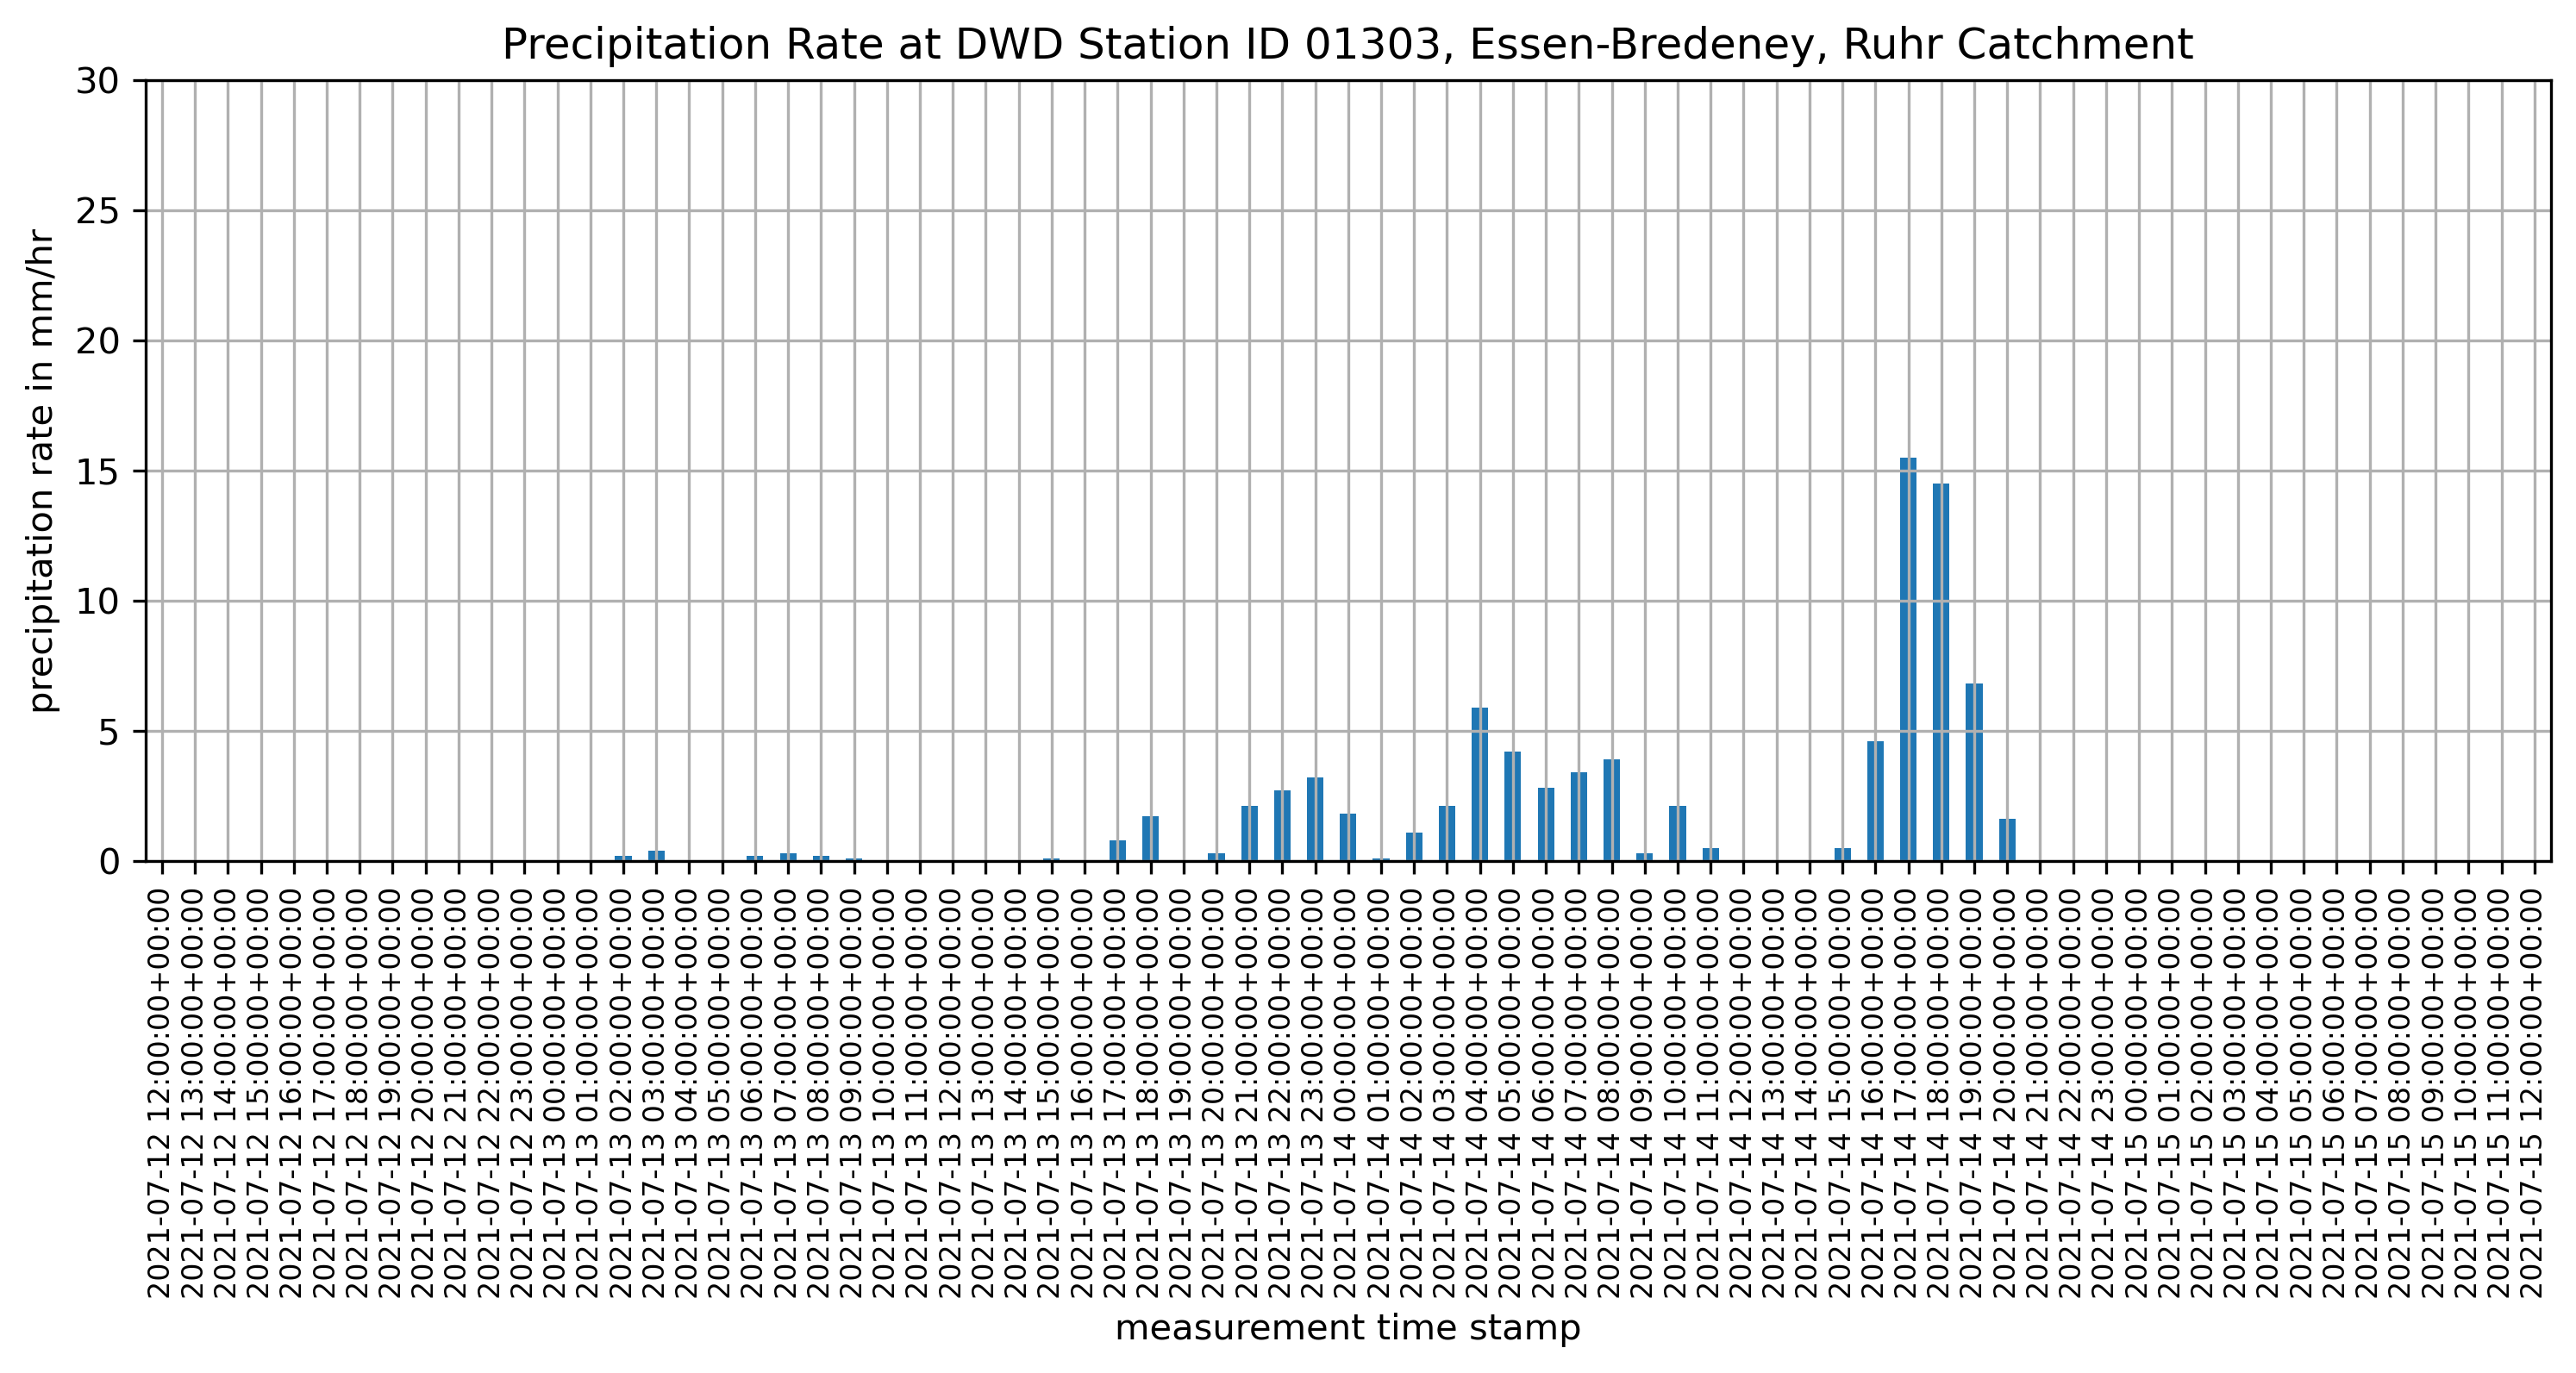

In [16]:
# Example plot of rain rate
fig1, ax1 = plt.subplots(figsize = (12,4), dpi = 300)
df_01303[idx_01303]["r1"].plot.bar(ax = ax1)
ax1.tick_params(axis='x', labelsize=8)
ax1.grid(True)
ax1.set_ylim(0,30)
ax1.set_title("Precipitation Rate at DWD Station ID 01303, Essen-Bredeney, Ruhr Catchment")
ax1.set_ylabel("precipitation rate in mm/hr")
ax1.set_xlabel("measurement time stamp")
plt.show()

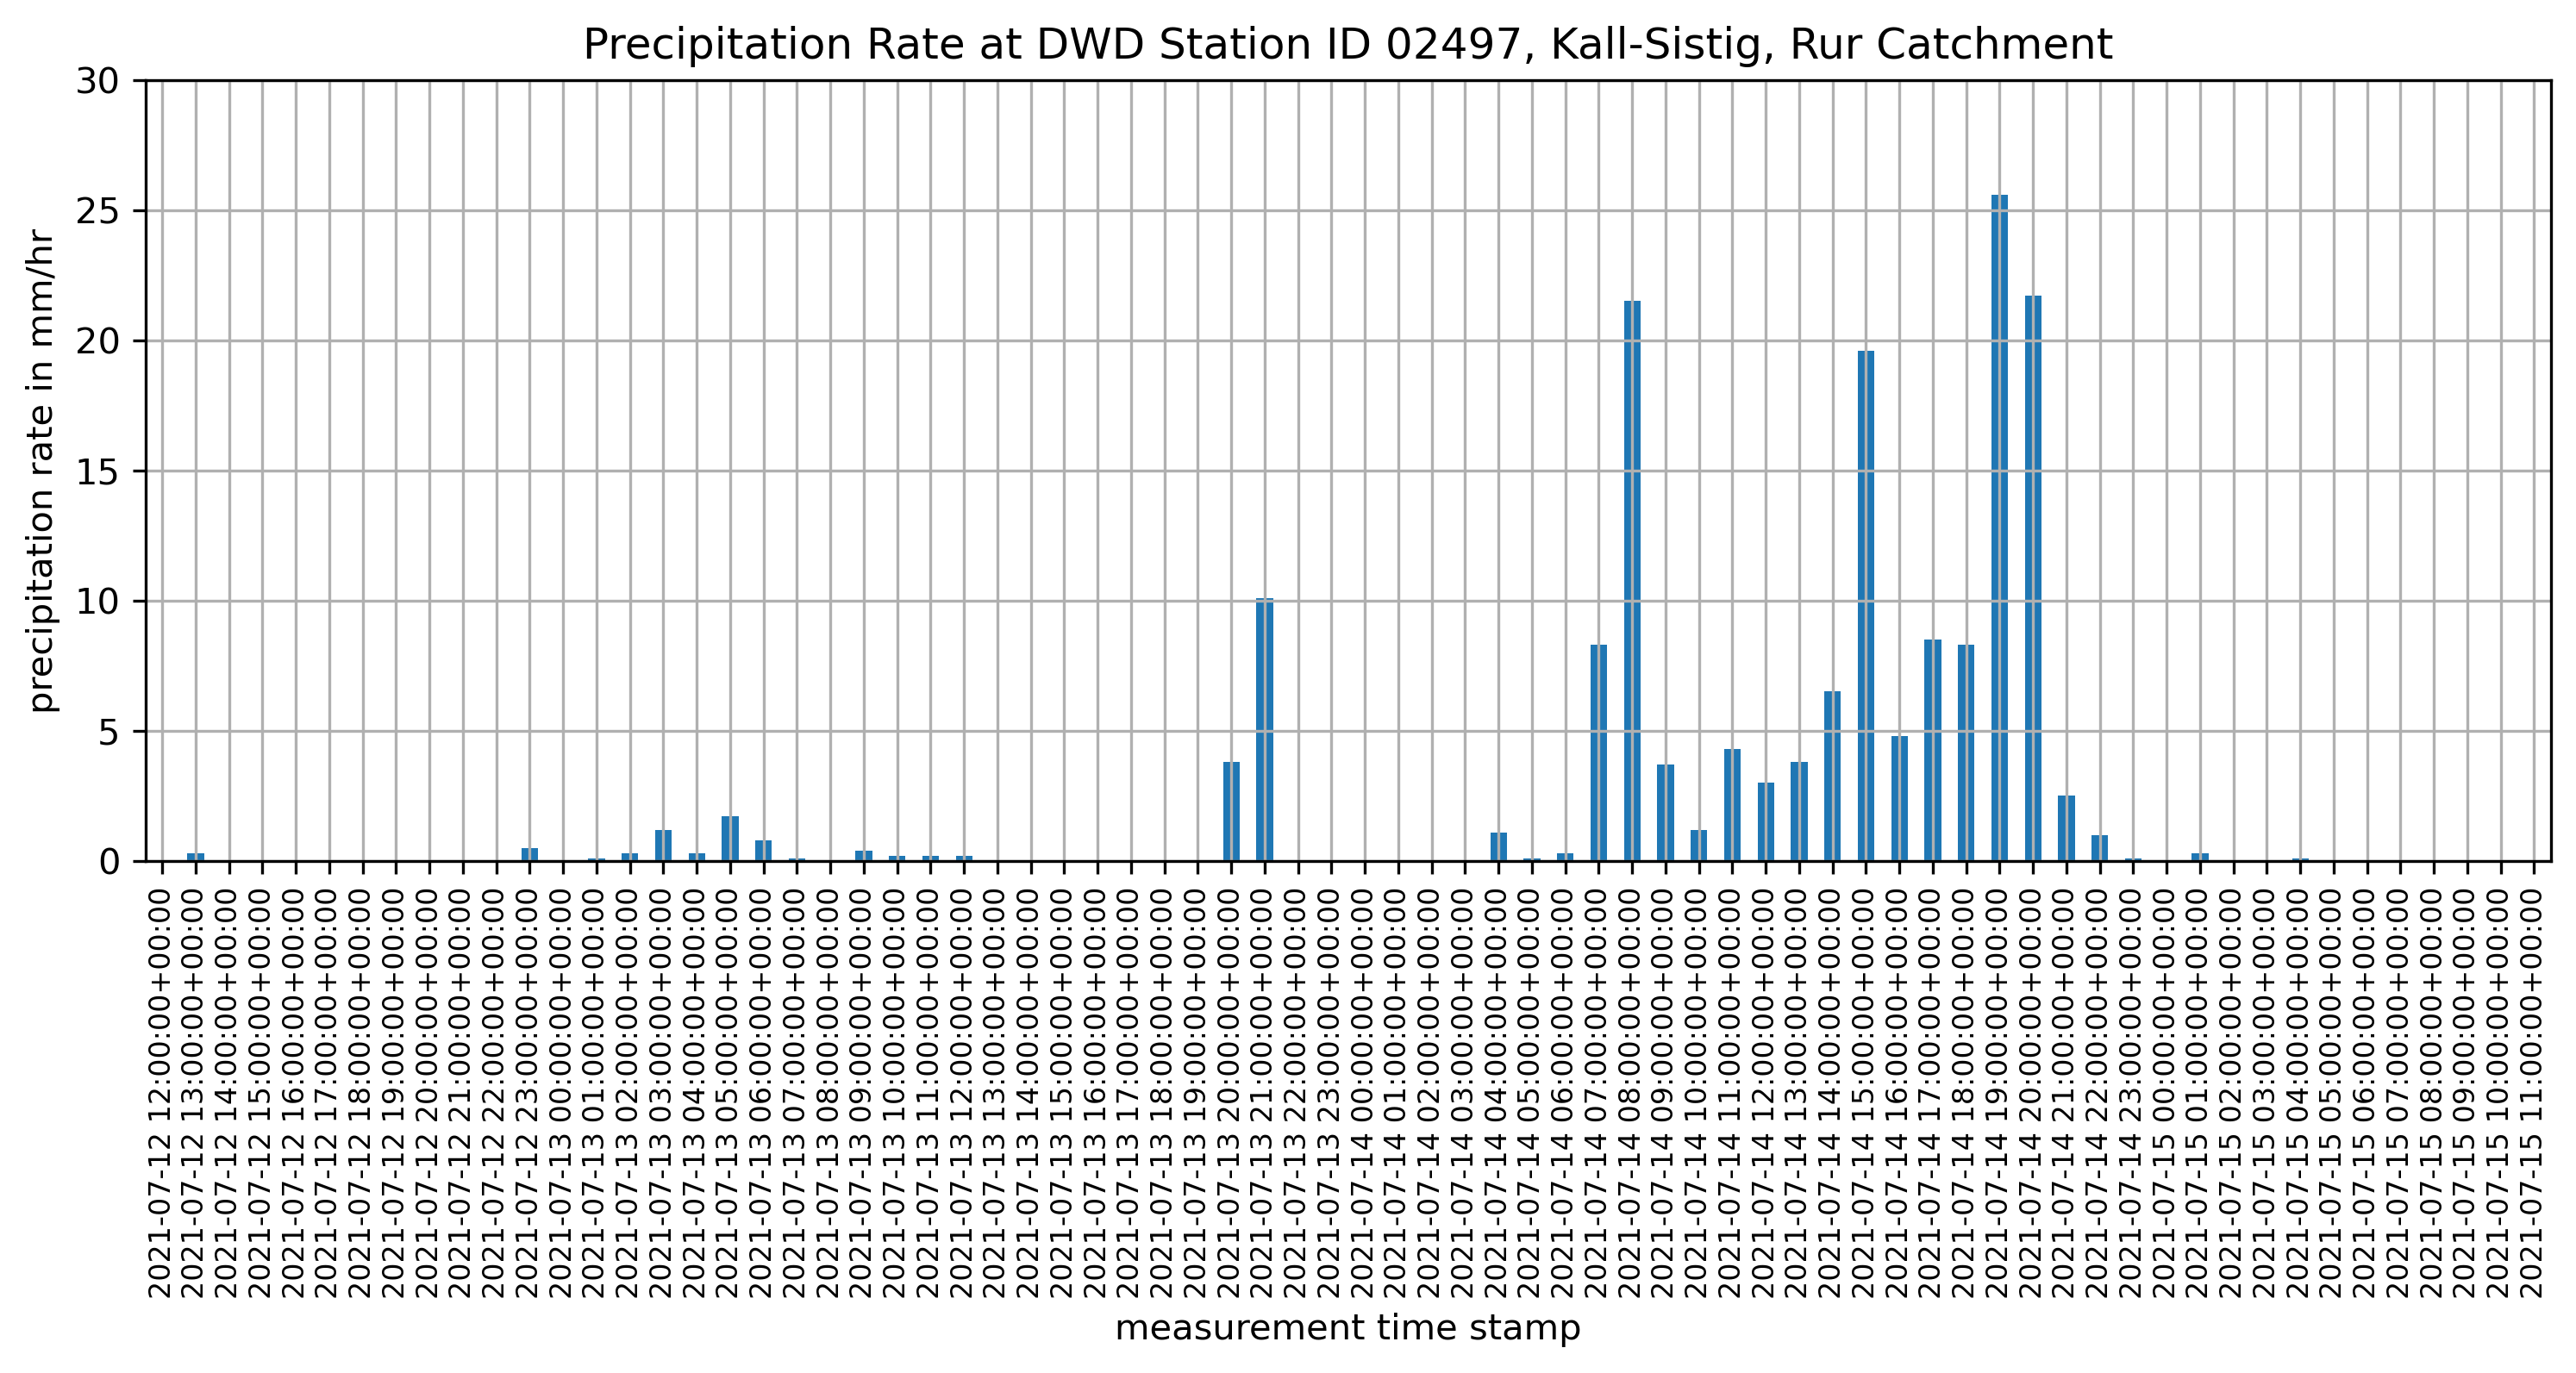

In [17]:
# Example plot of rain rate
fig2, ax2 = plt.subplots(figsize = (12,4), dpi = 300)
df_02497[idx_02497]["r1"].plot.bar(ax = ax2)
ax2.tick_params(axis='x', labelsize=8)
ax2.grid(True)
ax2.set_ylim(0,30)
ax2.set_title("Precipitation Rate at DWD Station ID 02497, Kall-Sistig, Rur Catchment")
ax2.set_ylabel("precipitation rate in mm/hr")
ax2.set_xlabel("measurement time stamp")
plt.show()

**Q 5.1:** Create a figure with **five subplots** (axes) arranged **vertically** showing the precipitation rates for the five selected stations. The plots should be **adjacent**, i.e. touching each other with only one time axis! Have a look at the  **[matplotlib example for creating adjacent subplots](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/ganged_plots.html#creating-adjacent-subplots)**. The y-axis scaling should be **identical** for all subplots in order to compare precipitation heights. Apply proper labeling (title, axis labels, etc.)

In [13]:
# fig, axs = ...
# axs is a tuple with subplot axis handles

# axs[0].plot(...)


## 6. Join the Data Frames

Slice the data frames to extract precipitation data only for relevant time interval only. Initialize an empty data frame `df_RR`, join it with the first extracted time series `R1` and overwrite it with the new joint data frame. 

Problem: The name of the next time series would also be `R1`, but the column names in the joined data frame must be unique. Therefore, each extracted time series must first be renamed before it is joined.

The code snippet below shows the procedure.

In [52]:
# Code cell "Join"
df_RR = pd.DataFrame()
df_RR = df_RR.join(df_01303[idx_01303]["r1"].rename("ID_01303"),how='outer')
df_RR = df_RR.join(df_02497[idx_02497]["r1"].rename("ID_02497"),how='outer')

# Join more series ...

df_RR.head()

,ID_01303,ID_02497
ts,,
2021-07-12 12:00:00+00:00,0.0,0.0
2021-07-12 13:00:00+00:00,0.0,0.3
2021-07-12 14:00:00+00:00,0.0,0.0
2021-07-12 15:00:00+00:00,0.0,0.0
2021-07-12 16:00:00+00:00,0.0,0.0


**Q 6.1:** Complete the code above to join the remaining three series!

## 7. Cumulative Precipitation

**Q 7.1:** Determine the cumulative precipitation. Use the function `cumsum()` to aggregate the precipitation time series gathered in df_RR. You can use either the [pandas version](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cumsum.html) or the [numpy version](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html). In fact cumsum() integrates the rain rate over time. It yields the growth of precipitation height (collected volume of water) over time. 


In [ ]:
# Code


**Q 7.2:** Plot the five cumulative precipitation sums as line graphs in one figure. Try to use the pandas data frame plot function, e.g. `df.plot(...)`.

In [53]:
# Code


**Q 7.3:** 1. Do you see a temporal shift between the step edges of strongly increasing precipitation? Can you order the stations according to the time of onset of heavy rain? Can you derive the motion of the rain event from this information?

**Q 7.4:** How much water did it rain at each station by the end of the event? Using a text editor, create another column in the CSV file `catchments.csv` for the total rainfall of the event, name it `total_prec_height` and enter the values.

**Q 7.5:** How much volume of water accumulated in the catchments during that event? Assume that the cumulative precipitation you determined at the five stations are representative for their whole catchments. How much water in $m^3$ was gathered in the five catchments? Take the final cumulative precipitation heights of the event at the five stations as well as the catchment areas into account. 


## 8. Make it smart!

**This is an exercise for the nerds. Try it! :-)**

The way of individual file processing like the code cell named "Read Data" is ugly and does not scale! Think of it as process to manage not just 5 but 
50 files ... :-(
<br>The same is true for the individual plot function calls or other subsequent analyses.

Instead, you could use a for loop to iterate over an iterable collection that contains all the product file paths that the system finds in subdirectories of the data directory. An example was given previously in the code cell which uses the `pathlib` library.

You get the full path to a product file right away! Calling of the function `prec_ts_to_df(pfname)` would be much easier than in the code cell "Read Data".

Within this loop the data frames can be joined one after the other as we did in the code cell named "Join". 

One challenge is the renaming of the sliced time series data frame (it is rather a pandas series) consisting of `R1` for the relevant time interval only. This series name will become the column name after joining. 

This series name has to be created automatically and should follow the template `ID_nnnnn` with `nnnnn` being the station ID. There are several ways to retrieve the station ID: It is part of the data subdirectory name, it is part of the product file name, and it is even in a column inside the product file name. 

Try to combine all the code snippets and ideas!


In [ ]:
# Code


## 9. Compare to Average July Precipitation Reference - Extra Excercise for Fun, not Graded!

Use **only one station** of your collection.

Compare the cumulative rainfall of the analyzed heavy rainfall event (amount of total rainfall that fell during the event) with the **average July rainfall** for the **years 1961 to 1990** at the selected station. Of course, you must select a station from your collection of five stations that provides this 30-year historical data. The 1961 to 1990 interval is a commonly used reference time interval. Changes are determined relative to this time period. 

Problem: The historical precipitation time series at hourly resolution that we have used so far do not go back far enough! Therefore more aggregated data i.e. at monthly resolution has to be used. The [**DWD KL data ensemble**](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/monthly/kl/historical/) (KL = Klima, climate) is providing monthly precipitation time series. 


**Q 9.1:** The KL data file format is different from the hourly RR data file format. You have to write your own import function, similar to the funtion `prec_ts_to_df(pfname)`.


In [69]:
# Code

# def kl_to_df(pfname):

# ...

# return(df_KL)


**Q 9.2:** Assume the `df_KL` data frame has a proper datetime64 time stamp as index.
<br> With `idx = (df_KL.index.month == 8) & (df_KL.index.year >= 2000)` you would select all August values for all the years later or equal 2000. You can use such a kind of index to select the monthly precipitation heights for the relevant reference period. Adapt and extend the index to create the required data slice. 

In [73]:
# Code

# idx = 
# df_ref = df_KL[idx]["..."] 

# df_ref

**Q 9.3:** What is the average July precipitation of the selected reference period?

In [74]:
# Code

# print ...

**Q 9.4:** What is the relationship between the July 2021 event precipitation (cumulative precipitation at the end of the heavy rain event) and the reference precipitation (mean July precipitation from 1961 to 1990)? Comment on the finding.

## Background Information

### Weather Attribution Science: Was the July 2021 Event Man-Made?

**_'Heavy rainfall which led to severe flooding in Western Europe made more likely by climate change'_**

https://www.worldweatherattribution.org/heavy-rainfall-which-led-to-severe-flooding-in-western-europe-made-more-likely-by-climate-change/


### Data Inconsistencies

Unfortunately there are inconsistencies in the DWD data availability. According to the station description file `RR_Stundenwerte_Beschreibung_Stationen.txt` the following station should provide hourly precipitation values at station 2500:

`02500 20040911 20220710            570     50.3953    6.9896 Kaltenborn, Hohe Acht                    Rheinland-Pfalz`

but the expected zip file containing the measurements for station 2500 as well as meta data is missing in the respective [download area](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/historical/).

This inconsistency in the data does not affect the current analysis, but you should be aware that you must always double check the integrity and correctness of the data you are working with. **Do not trust any data source or its quality without verifying it!**